In [252]:
import pandas as pd
import seaborn as sns
import string
import warnings
import matplotlib.pyplot as plt

from textblob import TextBlob
# from polyglot.detect import Detector

warnings.filterwarnings("ignore")

### 1. read in data

In [80]:
df = pd.read_csv('/home/jupyter/sb-entity-classification/data/data.csv')
classes_list = pd.read_csv('/home/jupyter/sb-entity-classification/data/classes.txt', header = None)

In [81]:
classes_list['class'] = classes_list.index
classes_list.columns = ['class_name', 'class']

df.columns = ['class','name']

In [82]:
classes_list.head(3)

,class_name,class
0,Company,0
1,EducationalInstitution,1
2,Artist,2


In [83]:
df.head(2)

,class,name
0,1,E. D. Abbott Ltd
1,1,Schwan-Stabilo


### 2. initial check of data quality

In [84]:
print('df has {} rows and {} cols'.format(df.shape[0], df.shape[1]))
df = df.drop_duplicates()
print('after dedup, df has {} rows and {} cols'.format(df.shape[0], df.shape[1]))

df has 548787 rows and 2 cols
after dedup, df has 548787 rows and 2 cols


In [85]:
df.isnull().sum()

class    0
name     0
dtype: int64

No null values or duplicates in data

In [86]:
if len(df['name'].unique()) == df.shape[0]:
    print('All good :) Every row has a distinct name in df')
else:
    print('Alert: The same name has been labeled as different classes.')

All good :) Every row has a distinct name in df


### 3. Distribution of examples among classes

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='class'>

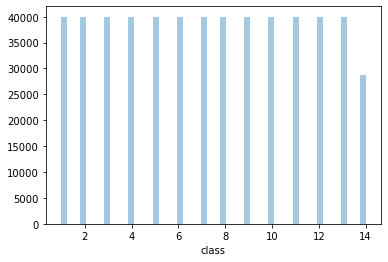

In [87]:
sns.distplot(df['class'], kde = False)

Same number of examples (40k) per class, except for the last class (30k examples)

In [88]:
classes_list

,class_name,class
0,Company,0
1,EducationalInstitution,1
2,Artist,2
3,Athlete,3
4,OfficeHolder,4
5,MeanOfTransportation,5
6,Building,6
7,NaturalPlace,7
8,Village,8
9,Animal,9


_Observation:_ 'class' in df starts from 1 instead of 0 as it does in classes_list, though both include 14 classes.

_Hypothesis:_ by pushing the index in classes_list by 1, the two sets will be able to joined.

_How to validate_: visually inspect a few examples per class to validate that they are well matched

In [89]:
classes_list['class'] = classes_list['class'] + 1

In [91]:
groups = df.groupby('class')

for i in classes_list['class'].unique():
    print('Examples of names for class {} are:'.format(classes_list[classes_list['class'] ==i]['class_name'].values[0]))
    example_names = groups.get_group(i).sample(5)['name'].values
    print(example_names, '\n')

Examples of names for class Company are:
['Brantano Footwear' 'Goldwind' 'List of record labels: R–Z'
 'Bank of Ayudhya' 'All Saints Records'] 

Examples of names for class EducationalInstitution are:
['Gabriel Richard Catholic High School' 'Wellington College Belfast'
 'University of Detroit Mercy School of Law' 'Zambian Open University'
 'Southwell Minster School'] 

Examples of names for class Artist are:
['Mafizuddin Ahmed Hazarika' 'Mandla Langa' 'Mark Cooke' 'Corin Tucker'
 'Björn Berglund'] 

Examples of names for class Athlete are:
['Josh Harding' 'Brent Geiberger' 'Willard Harrell' 'Sean Selmser'
 'Laura Handy'] 

Examples of names for class OfficeHolder are:
['Henrik Ramsay' 'Olin D. Johnston' 'Matias de Albuquerque'
 'R. Gregg Cherry' 'Mitchell Reiss'] 

Examples of names for class MeanOfTransportation are:
['USS Ash (AN-7)' 'MV Empire MacAndrew' 'SNCF Class Y 8400'
 'MV Loch Dunvegan' 'Hyak (steamboat 1909)'] 

Examples of names for class Building are:
['Shijimizuka site' '

_Observations_:
1. class name and class number are matched.
2. texts in name include:
(1) non-English words and non-ascii characters, such as 'Messaggero Veneto – Giornale del Friuli' and 'Otłoczynek'. 
(2) brackets and punctuation, such as 'Anna Lucasta (1959 film)' and 'I Want to Live!'. 
(3) some key words such as 'album' and 'film' are included in brackets, which could be especially useful for classification of genre. 
(4) length of texts in 'names' varies.  

### 4. Quantify the observed qualities of texts 

In [195]:
df_features = df.copy()
df_features = df_features.merge(classes_list, on = 'class')

#### 4.1 Length of texts in names and whether the distribution varies across classes.

In [196]:
df_features['num_chars'] = df['name'].str.len()

<AxesSubplot:xlabel='name_len'>

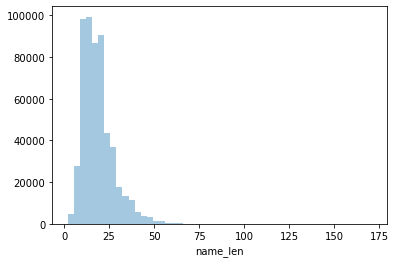

In [114]:
sns.distplot(df_features['num_chars'], kde = False)

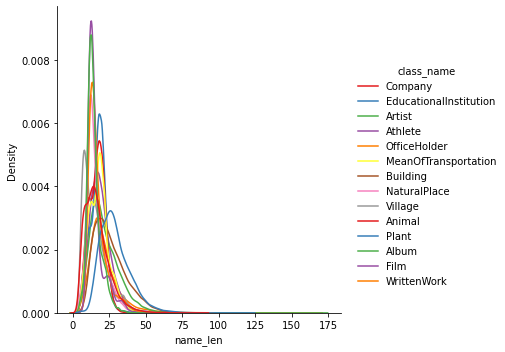

In [115]:
sns.displot(data=df_features, x='num_chars', hue='class_name', kind='kde', palette='Set1')

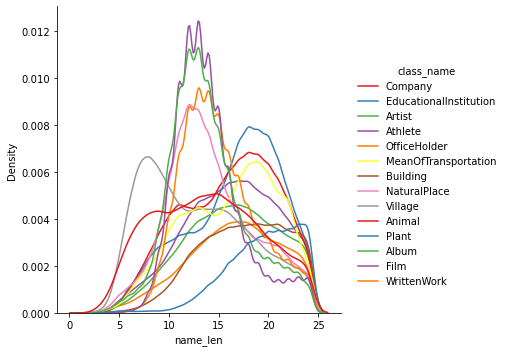

In [132]:
### Zoom in to the more dense area (without the long tail)
sns.displot(data = df_features[df_features['num_chars']<25], x='num_chars', hue='class_name', kind='kde', palette='Set1')

_Observations_:
1. Class 'Plant' seems more likely to have longer names (due to the fact that many of / potentially all of them are Latin names);
2. 'Athlete' and 'Artist', two classes that refer to human names, seem to have a similar distritbution of length, peaking more prominantly around 12 characters. Interestingly, OfficeHolder, another class that refers to human names, is slightly less concentrated at the medium length. 

#### 4.2 Number of words in names and whether the distribution varies across classes.

In [197]:
df_features['num_word'] = df_features['name'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='num_words'>

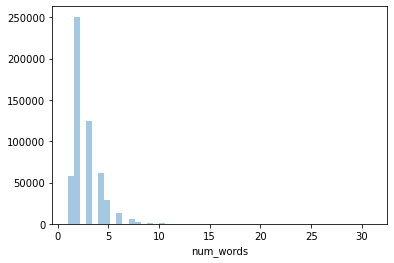

In [147]:
sns.distplot(df_features['num_words'], kde = False)

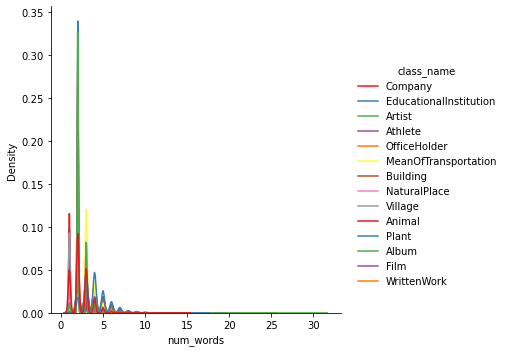

In [149]:
sns.displot(data=df_features, x='num_words', hue='class_name', kind='kde', palette='Set1')

<BarContainer object of 14 artists>

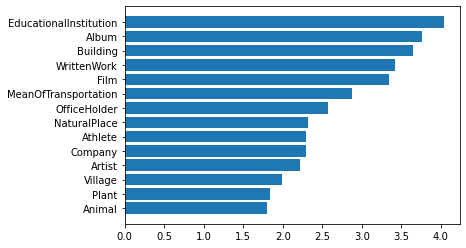

In [165]:
plt.barh(df_features.groupby('class_name').mean()['num_words'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_words'].sort_values(), 
         align='center')

Plant and Animals both have latin names, explaining the few, long words contained in their names.

#### 4.3 Number of punctuations, digits, nonascii characters in names and whether the distribution varies across classes.

In [212]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])  

In [209]:
df_features['num_punctuations']= df_features['name'].apply(lambda x: count(x,set(string.punctuation)))
df_features['num_ascii']= df_features['name'].apply(lambda x: count(x,set(string.ascii_letters)))
df_features['num_whitespace']= df_features['name'].apply(lambda x: count(x,set(string.whitespace)))
df_features['num_digits']= df_features['name'].apply(lambda x: count(x,set(string.digits)))

df_features['num_nonascii'] = df_features['num_chars']-df_features['num_punctuations']-df_features['num_digits']-df_features['num_ascii']- df_features['num_whitespace']

df_features = df_features.drop(['num_whitespace', 'num_ascii'], axis = 1)

In [213]:
df_features.head(2)

,class,name,class_name,num_chars,num_word,num_punctuations,num_digits,num_nonascii
0,1,E. D. Abbott Ltd,Company,16,4,2,0,0
1,1,Schwan-Stabilo,Company,14,1,1,0,0


<BarContainer object of 14 artists>

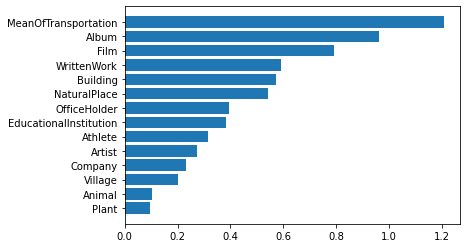

In [215]:
plt.barh(df_features.groupby('class_name').mean()['num_punctuations'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_punctuations'].sort_values(), 
         align='center')

<BarContainer object of 14 artists>

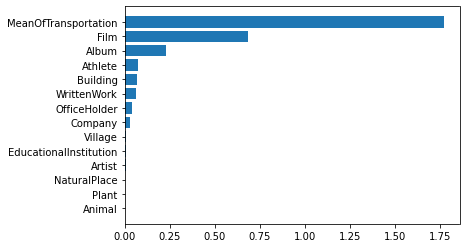

In [216]:
plt.barh(df_features.groupby('class_name').mean()['num_digits'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_digits'].sort_values(), 
         align='center')

<BarContainer object of 14 artists>

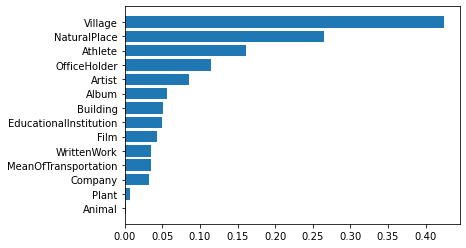

In [217]:
plt.barh(df_features.groupby('class_name').mean()['num_nonascii'].sort_values().index, 
         df_features.groupby('class_name').mean()['num_nonascii'].sort_values(), 
         align='center')

#### 4.4 Detected language in names and whether the distribution varies across classes.

In [240]:
def safe_detect_language(text):
    if len(text) >3:
        return TextBlob(text).detect_language()
    else:
        return None

In [241]:
df_features = df_features['name'].apply(lambda x: safe_detect_language(x))

HTTPError: HTTP Error 429: Too Many Requests